<a href="https://colab.research.google.com/github/isegura/iso4simplify/blob/main/select_fkgl_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip -q install sentence-transformers textstat


In [30]:
# Escribe los nombres de tus columnas
COL_ID='pair_id'
COL_COMPLEX='complex'   # texto original
COL_REF='simple'        # texto simplificado
# Número de ejemplos a generar
N_EXAMPLES=3
# Nombre del dataset
DATASET='tsar2024'

# Ruta relativa al fichero de training
PATH_TRAIN='data/tsar2024/cochraneauto_docs_train.csv'
# Ruta relativa de la template de prompts
TEMPLATE_PATH = "prompts/template_iso_few.md"
#spanihs, french
lang='english'

In [31]:
from google.colab import drive
import os, pandas as pd

# montar disco
drive.mount('/content/drive')
# Path del proyecto
PATH='/content/drive/MyDrive/iso4simplify'
os.chdir(PATH)


df = pd.read_csv(PATH_TRAIN)
print("Train size:", df.shape)
#print("Train columns:", df.columns)

df = df[[COL_ID, COL_COMPLEX, COL_REF]]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train size: (849, 10)


# 2) Representamos con embbeddings los textos


In [32]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
# Embeddings (normalizados para que dot product = cosine similarity)
emb_c = model.encode(df[COL_COMPLEX].tolist(), normalize_embeddings=True, show_progress_bar=True)
emb_s = model.encode(df[COL_REF].tolist(),  normalize_embeddings=True, show_progress_bar=True)
cosine_similarities = np.sum(emb_c * emb_s, axis=1)
# Cosine similarity por fila
df["similarity"] = cosine_similarities
df.head(2)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

,pair_id,complex,simple,similarity
0,CD012936,Three studies (146 participants) met our selec...,Three studies involving 146 participants were ...,0.808540
1,CD009102,"We included five trials, in which 1406 infants...",We found five studies that involved 1406 babie...,0.848671


In [33]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Vectorizador BoW (TF-IDF). Puedes ajustar ngram_range para capturar frases.
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words=lang,
    ngram_range=(1, 1),       # uni+bi-gramas suele ir mejor que solo (1,1)
    min_df=2
)

# Entrena vocabulario sobre ambos lados para no sesgar
all_texts = pd.concat([df[COL_COMPLEX], df[COL_REF]], ignore_index=True)
vectorizer.fit(all_texts)

Xc = vectorizer.transform(df[COL_COMPLEX])
Xs = vectorizer.transform(df[COL_REF])

# Similaridad coseno por fila (diagonal de la matriz de similitudes)
df["tfidf_sim"] = cosine_similarity(Xc, Xs).diagonal()
df.head()

,pair_id,complex,simple,similarity,tfidf_sim
0,CD012936,Three studies (146 participants) met our selec...,Three studies involving 146 participants were ...,0.808540,0.724938
1,CD009102,"We included five trials, in which 1406 infants...",We found five studies that involved 1406 babie...,0.848671,0.632472
2,CD011922,We included one randomized controlled trial (R...,We included and analyzed one randomized contro...,0.846761,0.864468
3,CD012318,We identified 31 studies (44 reports) includin...,Our search yielded 31 eligible studies compari...,0.753312,0.490856
4,CD010850,We included three studies (179 participants) c...,We searched to literature up to January 2016 a...,0.694931,0.444590


In [34]:
import textstat

df["fkgl_complex"] = (
    df[COL_COMPLEX]
    .fillna("")
    .apply(lambda x: textstat.flesch_kincaid_grade(str(x)))
)

df["fkgl_ref"] = (
    df[COL_REF]
    .fillna("")
    .apply(lambda x: textstat.flesch_kincaid_grade(str(x)))
)

df["fkgl_diff"] = df["fkgl_complex"] - df["fkgl_ref"]

print("Mean FKGL source: ", df["fkgl_complex"].mean())
print("Mean FKGL ref: ", df["fkgl_ref"].mean())

df[["fkgl_complex", "fkgl_ref", "fkgl_diff"]].describe()

Mean FKGL source:  11.8748766997518
Mean FKGL ref:  13.948014425242725


,fkgl_complex,fkgl_ref,fkgl_diff
count,849.000000,849.000000,849.000000
mean,11.874877,13.948014,-2.073138
std,2.805730,2.315110,3.140492
min,4.806884,6.416671,-11.202195
25%,9.824306,12.484286,-4.206395
50%,11.589359,13.931605,-2.008752
75%,13.626189,15.397653,0.231943
max,21.897488,21.136337,10.184097


<Axes: >

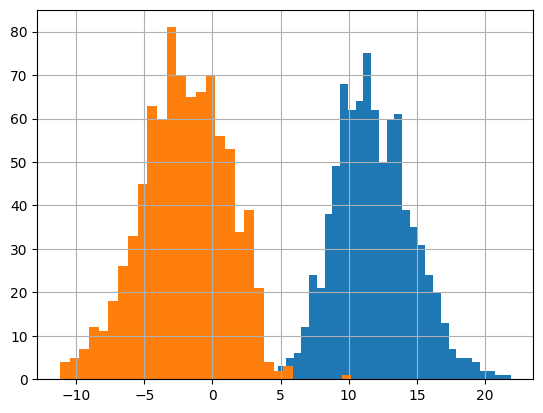

In [35]:
df["fkgl_complex"].hist(bins=30)
df["fkgl_diff"].hist(bins=30)


We selected in-context examples by filtering training pairs whose source texts had FKGL above the corpus median and whose simplifications resulted in a positive FKGL reduction between 1 and 6 points, ensuring genuine yet non-aggressive simplification.



In [36]:
df_filtered = df[
    (df["fkgl_complex"] >= 11.5) &
    (df["fkgl_diff"] >= 1.0) &
    (df["fkgl_diff"] <= 6.0)
]
print(df_filtered.shape)
df_filtered.head()

# Quitamos los que son muy similares léxicamente
df_filtered_bow = df_filtered[df_filtered["tfidf_sim"] < 0.9]

top_fkgl_sem_bow = df_filtered_bow.sort_values("similarity", ascending=False).head(N_EXAMPLES)
top_fkgl_sem_bow

(136, 8)


,pair_id,complex,simple,similarity,tfidf_sim,fkgl_complex,fkgl_ref,fkgl_diff
123,CD008929,We included nine studies in this review which ...,We included nine studies in this review which ...,0.943565,0.716816,14.835374,13.543749,1.291625
711,CD009257,We did not identify any randomised controlled ...,No randomised controlled trials were found tha...,0.926988,0.839317,17.330728,13.901739,3.428989
394,CD007286,"We included 10 RCTs (N = 1815), which were pub...","Ten trials met our inclusion criteria, and inc...",0.922204,0.777913,15.996380,11.516471,4.479909


#3) Cargamos el template del prompt


In [37]:
from pathlib import Path

DIR_PROMPTS='prompts'
os.makedirs(DIR_PROMPTS, exist_ok=True)


template_few = Path(TEMPLATE_PATH).read_text(encoding="utf-8")
examples = []

for i, row in top_fkgl_sem_bow.iterrows():
    examples.append({
        "id": row[COL_ID].strip(),
        "input": row[COL_COMPLEX].strip(),
        "output": row[COL_REF].strip()
    })

prompt_fewshot = template_few.format(
    ID_1=examples[0]["id"],
    EXAMPLE_1_INPUT=examples[0]["input"],
    EXAMPLE_1_OUTPUT=examples[0]["output"],

    ID_2 =examples[1]["id"],
    EXAMPLE_2_INPUT=examples[1]["input"],
    EXAMPLE_2_OUTPUT=examples[1]["output"],

    ID_3 =examples[0]["id"],
    EXAMPLE_3_INPUT=examples[2]["input"],
    EXAMPLE_3_OUTPUT=examples[2]["output"],
    INPUT_TEXT="{INPUT_TEXT}"  # placeholder para inferencia
)

OUTPUT_PATH = f"prompts/{DATASET}_fkgl_few_{N_EXAMPLES}.md"

with open(OUTPUT_PATH, "w", encoding="utf-8") as f:
    f.write(prompt_fewshot)

print("Prompt saved to:", OUTPUT_PATH)

Prompt saved to: prompts/tsar2024_fkgl_few_3.md


In [38]:

output_file = DIR_PROMPTS+f"/{DATASET}_fkgl_{N_EXAMPLES}.txt"

with open(output_file, "w", encoding="utf-8") as f:

    for idx, (_, row) in enumerate(top_fkgl_sem_bow.iterrows(), start=1):

        f.write("="*50 + "\n\n")

        f.write(f"EXAMPLE {idx} ({row[COL_ID]})\n")
        f.write("ORIGINAL:\n")
        f.write(str(row[COL_COMPLEX]).strip() + "\n\n")

        f.write("SIMPLIFIED TEXT:\n")
        f.write(str(row[COL_REF]).strip() + "\n\n")

    f.write("="*50 + "\n")

print("Fichero generado en:", os.path.abspath(output_file))

Fichero generado en: /content/drive/MyDrive/iso4simplify/prompts/tsar2024_fkgl_3.txt
